## FAES BIOF-509 Final Project
Author: Hale Kpetigo / hale.kpetigo@gmail.com

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import umap ###install with "pip install umap-learn"
import matplotlib.pyplot as plt
import seaborn as sns ### install using pip install seaborn

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from scipy.cluster.hierarchy import dendrogram


In [3]:
# Unsupervised Class
# 

class BIOF509Unsupervised:
    
    # My Variables
    #pd_data = []
    models = []
    labels = []
    reduced_pd_data = []
    scaled_data = []
    scaler = MinMaxScaler()
    
    # Constructor
    def __init__(self, file):
        # Call Data Loader
        self.load_data(file)
        self.prep_data()
        self.scale_data()
        #self.reduce_data()

    # Load dataset for analysis
    def load_data(self, file):
        self.pd_data = pd.read_csv(file)
        #make a copy of the raw data for future use
        self.raw_data = self.pd_data.copy(deep=True)
    
    def get_data(self):
        return self.pd_data
    
    # Prepare data - Seperate target from data
    def prep_data(self):
        self.labels = self.pd_data['target']
        del self.pd_data["target"]
    
    # helper to display target and head of the data
    def print_data(self):
        display(self.raw_data.head())
        display(self.pd_data.head())
        display(self.labels)
    
    # Pair plot analysis to display relationships between features in the dataset
    def plot_data(self):
        sns_plot = sns.pairplot(self.raw_data, hue='target')
        #sns.pairplot(self.raw_data, vars=self.raw_data.columns[:-1],hue='target')\
        #save plot to disk for report
        sns_plot.savefig("pairplot.png")
    
    def data_analysis(self):
        self.print_data()
        self.plot_data()
        
    def plot_clusters(self):
        #model = AgglomerativeClustering(n_clusters=3)
        #self.cluster_labels = model.fit_predict(self.scaled_data)
        self.reduce_data()
        sns.scatterplot(x='UMAP Dim. #1', y='UMAP Dim. #2',
            hue='cluster_labels', data=self.reduced_pd_data)
    
    def get_cluster_labels(self):
        model = AgglomerativeClustering(n_clusters=3)
        cluster_labels = model.fit_predict(self.scaled_data)
        return cluster_labels
    
    # Scale Data
    def scale_data(self):
        data_for_scaling = self.pd_data.values
        # scaler = MinMaxScaler()
        self.scaled_data = self.scaler.fit_transform(data_for_scaling)
        
        #for debuging purposes
        #print(self.scaled_data[0:5])
    
    # Recude Data
    def reduce_data(self):       
        data_reducer = umap.UMAP()
        
        umap_data = data_reducer.fit_transform(self.scaled_data)

        scaled_umap_data = self.scaler.fit_transform(umap_data)

        self.reduced_pd_data = pd.DataFrame(scaled_umap_data,columns=['UMAP Dim. #1', 'UMAP Dim. #2'])

        self.reduced_pd_data['cluster_labels'] = self.get_cluster_labels()
        
        #for debuging purposes
        #print(self.reduced_pd_data)
    
    def plotKmean_elbow(self):
        ks = list(range(1, 10))
        kmeans_models = []
        inertias = []

        for k in ks:
            model = KMeans(n_clusters=k, random_state=509).fit(self.scaled_data)
            kmeans_models.append(model)
            inertias.append(model.inertia_)
        
        fig1, ax1 = plt.subplots()
        ax1.plot(ks, inertias, '-x')
        ax1.set_title('KMean Elbow')
        ax1.set_ylabel('inertia')
        ax1.set_xlabel('k')
        #ax1.show()

    def compute_dbscan(self, _data, _truelabels):
        # Compute DBSCAN
        db = DBSCAN(eps=0.8, min_samples=16).fit(_data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(_truelabels, labels))
        print("Completeness: %0.3f" % metrics.completeness_score(_truelabels, labels))
        print("V-measure: %0.3f" % metrics.v_measure_score(_truelabels, labels))
        print("Adjusted Rand Index: %0.3f"
              % metrics.adjusted_rand_score(_truelabels, labels))
        print("Adjusted Mutual Information: %0.3f"
              % metrics.adjusted_mutual_info_score(_truelabels, labels))
        print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(_data, labels))
        
        #fig = plt.figure(figsize=(10, 10))
        #sns.scatterplot(_data[:,0], _data[:,7], hue=["cluster-{}".format(x) for x in labels])

        self.plot_dbscan(_data, labels, n_clusters_, core_samples_mask)

    def plot_dbscan(self, _data, labels, n_clusters_, core_samples_mask):
        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = _data[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 3], xy[:, 7], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = _data[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 3], xy[:, 7], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()
        
    def predict(self, _data, eps=[0.1*i for i in range(1,20)], min_samples=list(range(1,11))):
        self.eps = eps
        self.min_samples = min_samples
        _models = []
        _labels = []
        for e in eps:
            for ms in min_samples:
                model = DBSCAN(eps=e, min_samples=ms).fit(_data)
                _models.append(model)
                _labels.append(model.fit_predict(_data))
        return _models, _labels
    
    def accuracy(self, target, _models, _labels):
        score = []
        for pred in _labels:
            score.append(self.max_score(pred, target))
        
        max_ind = np.argmax(score)
        best_model = _models[max_ind]
        print('Max accuracy {} with model {}'.format(score[max_ind], best_model))
        return best_model
    
    def max_score(self, pred, target):
        permutations = [[0, 1], [1, 0]]
        scores = []
        for perm in permutations:
            n_right = 0
            for label, t in zip([0, 1], perm):
                n_right += sum((pred == label)*(target == t)*1)
            scores.append(n_right/len(pred))
        return max(scores)
    
    def plot_dendrogram(self,model, **kwargs):
        # from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
        # Create linkage matrix and then plot the dendrogram

        # create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count

        linkage_matrix = np.column_stack([model.children_, model.distances_,
                                          counts]).astype(float)

        # Plot the corresponding dendrogram
        dendrogram(linkage_matrix, **kwargs)
    
    def BIOF509Kmeans(self):
        self.plot_clusters()
        self.plotKmean_elbow()
    
    def BIOF509Density(self):
        mdls, lbls = self.predict(self.scaled_data)
        mytarget = self.labels
        np_lbl = mytarget.array #convert to np
        
        best_model = self.accuracy(np_lbl, mdls, lbls)
        
        # Try without age and sex features
        mdls, lbls = self.predict(self.scaled_data[:, 2:14])
        best_model_reduced = self.accuracy(np_lbl, mdls, lbls)
        
        self.compute_dbscan(self.scaled_data, self.labels)
        
    def BIOF509Hierarchical(self):
        model = AgglomerativeClustering(distance_threshold=2, n_clusters=None)
        labels = model.fit_predict(self.scaled_data)
        self.plot_dendrogram(model, truncate_mode='level', p=2)
        plt.xlabel("Number of points in node (or index of point if no parenthesis).")
        plt.show()
        self.plotHierarchy_elbow()
    
    def plotHierarchy_elbow(self):
        # vary parameters
        thresh = list(range(10))
        agg_models = []
        n_clusters = []

        for t in thresh:
            model = AgglomerativeClustering(distance_threshold=t, n_clusters=None).fit(self.scaled_data)
            agg_models.append(model)
            n_clusters.append(model.n_clusters_)
            
        fig2, ax2 = plt.subplots()    
        ax2.plot(thresh, n_clusters, '-x')
        display(n_clusters)
        
        # plotting with agglomerative model labels
        # When non continuous values value features are incluter the plot is linear as opposed to being globular
        fig3, ax3 = plt.subplots()
        # age:0 vs Max: heart rate:7 -> Globular
        # age:0 vs sex: 1 -> linear
        ax3.scatter(self.scaled_data[:,0], self.scaled_data[:,7], c=agg_models[2].labels_.astype(float))

Max accuracy 0.5478547854785478 with model DBSCAN(eps=1.1, min_samples=1)
Max accuracy 0.6039603960396039 with model DBSCAN(eps=0.8, min_samples=6)
Estimated number of clusters: 3
Estimated number of noise points: 79
Homogeneity: 0.203
Completeness: 0.103
V-measure: 0.137
Adjusted Rand Index: 0.092
Adjusted Mutual Information: 0.133
Silhouette Coefficient: 0.219


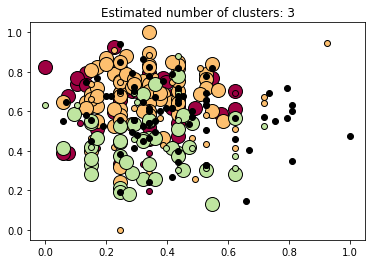

In [4]:
FinalProject = BIOF509Unsupervised("heart 2.csv")
# Second dataset used for comparision
# FinalProject = BIOF509Unsupervised("heart.csv")
#FinalProject.data_analysis()

# Use one alogrithm at a time
#FinalProject.BIOF509Kmeans()
FinalProject.BIOF509Density()
#FinalProject.BIOF509Hierarchical()



In [5]:
class BIOF509Supervised:
    
    """My Variables"""
    pd_data = []
    labels = []
    scaled_data = []
    reduced_pd_data = []

    # Constructor
    def __init__(self, file):
        # Call Data Loader
        self.load_data(file)
        self.prep_data()
        
    # Load data set for analysis
    def load_data(self, file):
        self.pd_data = pd.read_csv(file)
    
    def prep_data(self):
        self.labels = self.pd_data['target']
        del self.pd_data["target"]
    

    def BIOF509SVM(self):
        svm_model = SVC(kernel='linear')
        skf = StratifiedKFold(n_splits=5,shuffle=True)
        all_feature_importances = np.zeros((len(set(self.labels)),len(self.pd_data.columns)))
        all_labels = []
        all_predictions = []

        accuracy = 0

        for train_index, test_index in skf.split(self.pd_data.values, self.labels):

                # training dataset
                X_train, y_train = self.pd_data.values[train_index], self.labels[train_index]

                # testing dataset
                X_test, y_test = self.pd_data.values[test_index], self.labels[test_index]

                # fit the model to the data
                svm_model.fit(X_train,y_train)

                # finds features importance
                all_feature_importances += svm_model.coef_

                # Predicts targets
                predictions = svm_model.predict(X_test)
                
                # Add predictions to set
                all_predictions.extend(predictions)

                
                # Add new label to set
                all_labels.extend(y_test)

                # Add accuracy score
                accuracy += accuracy_score(predictions,y_test)

        print("PREDICTION ACCURACY")
        print(accuracy/5)
         
        # Plot Confusion Matrix
        cm = confusion_matrix(all_labels,all_predictions,normalize= 'true')
        df_cm = pd.DataFrame(cm,index=[0,1],columns=[0,1])
        sns.heatmap(df_cm, annot=True)
        
        # Plot Inportance of features
        average_feature_importances = []

        for i in range(all_feature_importances.shape[1]):
            average_value = 0
            for array in all_feature_importances:
                average_value += abs(array[i])
            average_feature_importances.append(average_value/3) 

        plt.figure(figsize = (15,10))
        plt.bar(list(self.pd_data.columns),average_feature_importances, color ='blue',  width = 0.4) 
        plt.title('Feature Importances')
        
        
    def BIOFDecisionTree(self):
        
        print('**Decision Tree')
        
        # Setting data attributes
        X = self.pd_data
        # Setting target
        y = self.labels

        print('Dataset size:', X.shape[0])

        # Using the train_test_split to create train and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47, test_size = 0.33)
        
        # Importing the Decision tree classifier from the sklearn library.
        from sklearn.tree import DecisionTreeClassifier
        clf = DecisionTreeClassifier(criterion = 'entropy')
        
        # Training the decision tree classifier. 
        clf.fit(X_train, y_train)
            
        # Predicting labels on the test set.
        y_pred =  clf.predict(X_test)
        
        print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
        print('Accuracy Score on test data: ', accuracy_score(y_true=y_test, y_pred=y_pred))

        clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)
        clf.fit(X_train, y_train)
        print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
        print('Accuracy Score on the test data: ', accuracy_score(y_true=y_test, y_pred=clf.predict(X_test)))
        print('***')
        
    def BIOFBayesian(self):
        
        print('**GaussianNB')
        # Setting data attributes
        X = self.pd_data
        # Setting target
        y = self.labels
        
        print('Dataset size:', X.shape[0])

        # Using the train_test_split to create train and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47, test_size = 0.33)
        
        #x_train, y_train, x_test, y_test = datasets.breastcancer_cont(replication=1)
        #train_data, test_data = datasets.breastcancer_cont_discomll(replication=1)

        clf = GaussianNB()
        probs_log1 = clf.fit(X_train, y_train).predict_proba(X_test)
        
        y_pred =  clf.predict(X_test)
        
        #res = clf.score(X_test, y_test)
        #display(res)
        
        print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
        print('Accuracy Score on test data: ', accuracy_score(y_true=y_test, y_pred=y_pred))
        


PREDICTION ACCURACY
0.8383060109289617


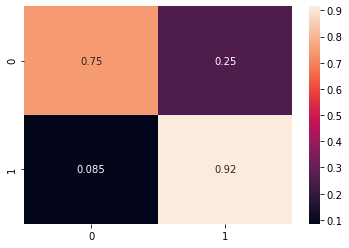

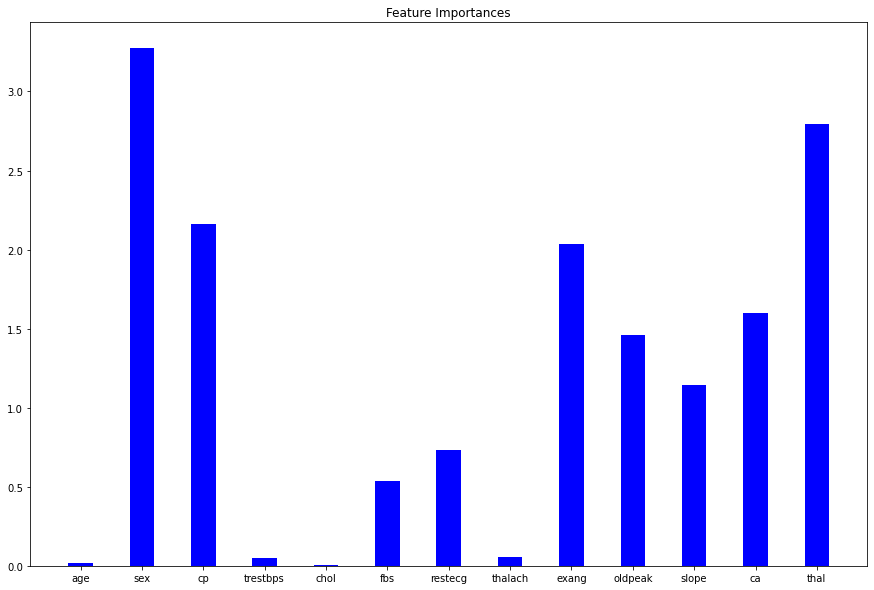

In [20]:
FinalSupProject = BIOF509Supervised("heart 2.csv")
#FinalSupProject = BIOF509Supervised("heart.csv")

FinalSupProject.BIOF509SVM()

#FinalSupProject.BIOFDecisionTree()

#FinalSupProject.BIOFBayesian()